In [1]:
import numpy as np
import os, psutil # used to monitor memory usage
from   glob import glob

import pylab as pl
import pandas as pd

from astropy.table import Table
from astropy.io import fits

from tqdm.notebook import tqdm

In [20]:
import torch
from torch            import nn
from torch            import FloatTensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn         import functional as F

from torchvision      import transforms
from torchvision.models import feature_extraction
from torchvision.models import vit_l_16,  ViT_L_16_Weights
from torchvision.models import vit_l_32,  ViT_L_32_Weights
from torchvision.models import swin_b, Swin_B_Weights
from torchvision.models import swin_s, Swin_S_Weights
from torchvision.models import swin_t, Swin_T_Weights
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import resnet152, ResNet152_Weights

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [3]:
batch_size = 16
epochs     = 20
lr         = 0.1 
modelname  = 'vitl32'
name       = 'test'

In [4]:
pl.style.use('/pscratch/sd/j/jfsuarez/plots.mplstyle')

In [5]:
class GalaxyNet(torch.nn.Module):
    def __init__(self, pretrained=True, modelname='swins'):
        super().__init__()
        #print('hiii', model)
        if modelname=='vitl16':
            model = vit_l_16(weights=ViT_L_16_Weights.DEFAULT)
        elif modelname=='vitl32':
            model = vit_l_32(weights=ViT_L_32_Weights.DEFAULT)
        elif modelname=='swinb':
            model = swin_b(weights=Swin_B_Weights.DEFAULT)
        elif modelname=='swins':
            model = swin_s(weights=Swin_S_Weights.DEFAULT)
        elif modelname=='swint':
            model = swin_t(weights=Swin_T_Weights.DEFAULT)
        elif modelname=='resnet18':
            model = resnet18(weights=ResNet18_Weights.DEFAULT)
        elif modelname=='resnet50':
            model = resnet50(weights=ResNet50_Weights.DEFAULT)
        elif modelname=='resnet152':
            model = resnet152(weights=ResNet152_Weights.DEFAULT)

        else:
            print('Other model doesnt exist')
        
        count = 0
        #print(model)
        for child in model.children():  
            count += 1
            if count < 7:    
                for param in child.parameters():
                    param.requires_grad = False

        # for param in model.parameters():
        #     param.requires_grad = False        
        
        model.load_state_dict(model.state_dict())     
        
        self.features = torch.nn.ModuleList(model.children())[:-1]
        self.features = torch.nn.Sequential(*self.features)
        
        if 'swin' in modelname:
            self.fc1 = torch.nn.Linear(model.head.in_features, 768)
            self.fc2 = torch.nn.Linear(768, 256)
            
        elif 'vit' in modelname:
            self.fc1 = torch.nn.Linear(model.heads.head.in_features, 768)
            self.fc2 = torch.nn.Linear(768, 256)
            
        elif 'resnet' in modelname:
            self.fc1 = torch.nn.Linear(model.fc.in_features, 512)
            self.fc2 = torch.nn.Linear(512, 256)

        self.fc3 = torch.nn.Linear(256, 1)        
        
    def forward(self, x):
        #-Call Features
        x = self.features(x)
        
        #-Flatten
        x = x.view(x.size(0), -1)
        
        # and also our new layers 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [6]:
class ReadDataset(Dataset):
    def __init__(self, data_paths, data):
        self.data_files = data_paths 
        self.data = data
        self.data_transforms = transforms.Compose([
            # transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
    
    def __getitem__(self, index):
        TID = int(self.data_files[index].split('/')[-1].split('_')[1])
        #print(TID)
        #print(self.data_files[index])
        x = fits.open(self.data_files[index])
        #print(x)
        x = np.dstack([x[1].data, x[2].data, x[3].data])
        #print(x, type(x))
        x = self.data_transforms(x)
        #print(x)
        
        y = np.array(self.data['Z'][self.data['TARGETID']==TID], dtype=float)[0]
        y = torch.tensor(y).float()
        #print(x,y)
        return x, y
    
    def __len__(self):
        return len(self.data_files)

In [7]:
def tensor2img(tensor):
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    img_restore = tensor * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    return transforms.ToPILImage()(img_restore)

In [8]:
def train(model, epoch, dataloader, device, optimizer, criterion):
    model.train()
    #print('Training...')
    
    #- Start the train loop
    for batch_id, (X_batch, Y_batch) in enumerate(dataloader):
        #print(batch_id, len(dataloader))
        
        #- Send data to device 
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        #- Make the prediction
        Y_pred = model(X_batch).squeeze()
        #print(Y_pred.size())

        #- Compute the loss
        loss = criterion(Y_pred, Y_batch)

        #- Back Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print('Optimization')

    print(f'Epoch:{epoch} - Loss_Train:{loss.item():.4f}')        
    return loss.item()


def valid(model, epoch, dataloader, device, criterion):
    model.eval()
    #print('Testing...')
    
    #- Start the test loop
    for batch_id, (X_batch, Y_batch) in enumerate(dataloader):
        
        #- Send data to device 
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        #- Make the prediction
        Y_pred = model(X_batch).squeeze()

        #- Compute the loss
        loss = criterion(Y_pred, Y_batch)

    print(f'Epoch:{epoch} - Loss_Valid:{loss.item():.4f}')        
    return loss.item()

### Preparing the data

In [9]:
catalog = './../../data/deepgn/catalog_guadalupe_main_bgs/photo_features_full.csv'

Z_lim = 0.6

data = Table.read(catalog)
data = data[(data['Z']<Z_lim) & (data['FLUX_W1']>0)& (data['FLUX_W2']>0)]

dirdata = catalog[:catalog.rfind('/')]

def pathfit(lab,tid,ra,dec):
    if dec>0:
        file = f'{dirdata}/photo/{lab}/DESI_{tid}_{float(ra)}+{float(dec)}.fits'
    else:
        file = f'{dirdata}/photo/{lab}/DESI_{tid}_{float(ra)}{float(dec)}.fits'
    return file

train_files = []
test_files  = []
valid_files = []

for i in range(len(data)):
    d = data[i]
    if d['LABEL']=='train':
        train_files.append(pathfit(d['LABEL'], d['TARGETID'], d['TARGET_RA'], d['TARGET_DEC']))
    elif d['LABEL']=='valid':
        valid_files.append(pathfit(d['LABEL'], d['TARGETID'], d['TARGET_RA'], d['TARGET_DEC']))
    elif d['LABEL']=='test':
        test_files.append(pathfit(d['LABEL'], d['TARGETID'], d['TARGET_RA'], d['TARGET_DEC']))

train_files = train_files[:1000]
valid_files = valid_files[:100]
test_files  = test_files[:100]

In [10]:
#- Number of objects
N = len(train_files)+len(valid_files)+len(test_files)
print(f'#####\n There are {N} objects\n#####')

print(f'#######\n Train Size: {len(train_files)}')
print(f' Valid  Size: {len(valid_files)}')
print(f' Test  Size: {len(test_files)}\n#######')

train_dataset = ReadDataset(train_files, data)
valid_dataset = ReadDataset(valid_files, data)
test_dataset  = ReadDataset(test_files, data)

#####
 There are 1200 objects
#####
#######
 Train Size: 1000
 Valid  Size: 100
 Test  Size: 100
#######


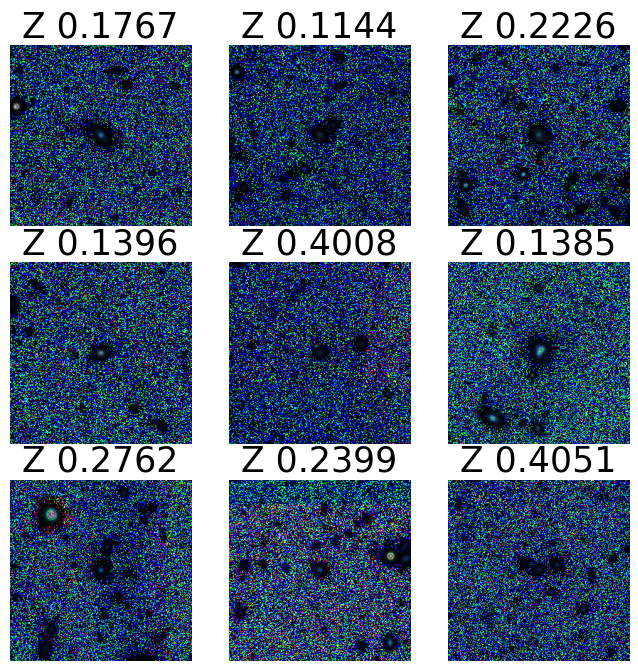

In [11]:
figure = pl.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, tgt = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    pl.title(f'Z {tgt:.4f}')
    pl.axis("off")
    pl.imshow(tensor2img(img))
pl.show()

In [12]:
#- Define the batch_size
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset,  batch_size=batch_size, shuffle=True)
test_dataloader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=True)

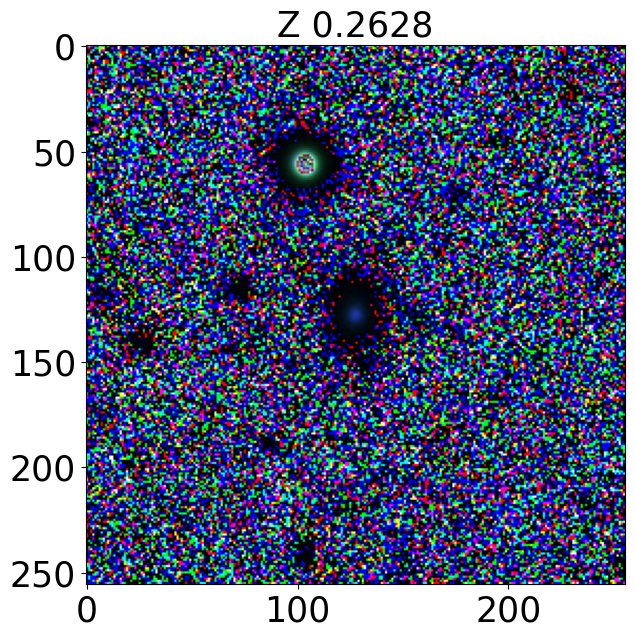

In [13]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
img = train_features[0].squeeze()
label = train_labels[0]
pl.title(f'Z {label:.4f}')
pl.imshow(tensor2img(img))
pl.show()

### Load the model

In [14]:
checkpoint_file = f'./model/deeptest/model__checkpoint.pt'

In [15]:
#- Define the device cpu/gpu
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

#- Define the model
model = GalaxyNet(modelname=modelname)

loss_train = []
loss_valid = []
last_epoch = 0
min_loss_train = 1

#- Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=lr) 

#- Define the criterion
criterion = torch.nn.MSELoss()

models = np.sort(glob(checkpoint_file.replace('checkpoint','checkpoint_e*')))

if (len(models) != 0):
    checkpoint = torch.load(models[-1])
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    last_epoch = checkpoint['epoch']
    loss_train = checkpoint['loss_train']
    loss_valid = checkpoint['loss_valid']
    print(f'Loading a checkpoint... on epoch:{last_epoch}')

print('---> Number of params: {}'.format(sum([p.data.nelement() for p in model.parameters()])))

#- Send the model to the device
model = model.to(device)

cuda:0
---> Number of params: 306493697


In [16]:
pbar = tqdm(total=epochs)
for epoch in range(last_epoch,epochs):
    epoch = epoch + 1
    loss_train.append( train(model, epoch, train_dataloader, device, optimizer, criterion) )
    loss_valid.append( valid(model, epoch, valid_dataloader, device, criterion) )

    last_loss_train = loss_train[-1]
    last_loss_valid = loss_valid[-1]

    # Save model checkpoint by epoch
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss_train': loss_train,
                'loss_valid': loss_valid
                }, checkpoint_file.replace('checkpoint',f'checkpoint_e{epoch:03d}'))    
    
    # If loss is less than min_loss save like best model
    if last_loss_train < min_loss_train:
        min_loss_train = last_loss_train
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss_train': loss_train,
                    'loss_valid': loss_valid
                    }, checkpoint_file.replace('checkpoint','checkpoint_best'))
    pbar.update()
pbar.close()

fig = pl.figure(figsize=(8,4))
pl.plot(loss_train, label='Train')
pl.plot(loss_valid, label='Valid')
pl.legend()
#pl.savefig(f'{save_path}/Loss_RegPhoto_{name}.png', bbox_inches='tight')
pl.show()

#- Put the model on test mode
model.eval()
with torch.no_grad():
    Y_pred = []
    Y_test = []
    for batch_idx, (data, target) in enumerate(test_dataloader):    
        data = FloatTensor(data)
        target = FloatTensor(target)
        data   = data.to(device)
        target = target.to(device)        
        Y_pred.append(model(data).cpu().squeeze().detach().numpy())
        Y_test.append(target.cpu().detach().numpy())
    Y_predtest = np.concatenate([np.ravel(i) for i in Y_pred])
    Y_test = np.concatenate([np.ravel(i) for i in Y_test])

    Y_pred = []
    Y_train = []    
    for batch_idx, (data, target) in enumerate(train_dataloader):    
        data = FloatTensor(data)
        target = FloatTensor(target).view(len(target), -1)
        data   = data.to(device)
        target = target.to(device)        
        Y_pred.append(model(data).cpu().squeeze().detach().numpy())
        Y_train.append(target.cpu().detach().numpy())
    Y_predtrain = np.concatenate([np.ravel(i) for i in Y_pred])
    Y_train = np.concatenate([np.ravel(i) for i in Y_train])

fig = pl.figure(figsize=(20,5))
pl.subplot(1,3,1)
pl.scatter(Y_predtest, Y_test, alpha=0.5)
maxx = max(max(Y_predtest),max(Y_test))
pl.plot([0, maxx], [0, maxx], '--')
pl.xlabel(r'$z_{pred}$')
pl.ylabel(r'$z_{test}$')
pl.title(r'$z_{pred}$ - $z_{test}$'+f'\n'+r'$r^2$'+f'={r2_score(Y_test, Y_predtest):.3f}   -    MSE={mean_squared_error(Y_test, Y_predtest):.4f}')
pl.subplot(1,3,2)
_ = pl.hist(Y_predtest - Y_test, label=r'$z_{pred}$ - $z_{test}$', alpha=0.5)
pl.legend()
pl.subplot(1,3,3)
_ = pl.hist(Y_predtest, label='Pred', alpha=0.5)
_ = pl.hist(Y_test, label='Test', alpha=0.5)
pl.legend()
pl.show()
#pl.savefig(f'{save_path}/RegPhoto_test_{name}.png', bbox_inches='tight')

fig = pl.figure(figsize=(20,5))
pl.subplot(1,3,1)
pl.scatter(Y_predtrain, Y_train, alpha=0.5)
maxx = max(max(Y_predtrain),max(Y_train))
pl.plot([0, maxx], [0, maxx], '--')
pl.xlabel(r'$z_{pred}$')
pl.ylabel(r'$z_{train}$')
pl.title(r'$z_{pred}$ - $z_{train}$'+f'\n'+r'$r^2$'+f'={r2_score(Y_train, Y_predtrain):.3f}   -    MSE={mean_squared_error(Y_train, Y_predtrain):.4f}')
pl.subplot(1,3,2)
_ = pl.hist(Y_predtrain - Y_train, label=r'$z_{pred}$ - $z_{train}$', alpha=0.5)
pl.legend()
pl.subplot(1,3,3)
_ = pl.hist(Y_predtrain, label='Pred', alpha=0.5)
_ = pl.hist(Y_train, label='train', alpha=0.5)
pl.legend()
pl.show()
#pl.savefig(f'{save_path}/RegPhoto_train_{name}.png', bbox_inches='tight')

  0%|          | 0/20 [00:00<?, ?it/s]

AssertionError: Expected (batch_size, seq_length, hidden_dim) got torch.Size([16, 1024, 8, 8])

In [ ]:
#- Put the model on test mode
model.eval()
with torch.no_grad():
    Y_pred = []
    Y_test = []
    for batch_idx, (data, target) in enumerate(test_dataloader):    
        data = FloatTensor(data)
        target = FloatTensor(target)
        data   = data.to(device)
        target = target.to(device)        
        Y_pred.append(model(data).cpu().squeeze().detach().numpy())
        Y_test.append(target.cpu().detach().numpy())
    Y_predtest = np.concatenate([np.ravel(i) for i in Y_pred])
    Y_test = np.concatenate([np.ravel(i) for i in Y_test])

    Y_pred = []
    Y_train = []    
    for batch_idx, (data, target) in enumerate(train_dataloader):    
        data = FloatTensor(data)
        target = FloatTensor(target).view(len(target), -1)
        data   = data.to(device)
        target = target.to(device)        
        Y_pred.append(model(data).cpu().squeeze().detach().numpy())
        Y_train.append(target.cpu().detach().numpy())
    Y_predtrain = np.concatenate([np.ravel(i) for i in Y_pred])
    Y_train = np.concatenate([np.ravel(i) for i in Y_train])

fig = pl.figure(figsize=(20,5))
pl.subplot(1,3,1)
pl.scatter(Y_predtest, Y_test, alpha=0.5)
maxx = max(max(Y_predtest),max(Y_test))
pl.plot([0, maxx], [0, maxx], '--')
pl.xlabel(r'$z_{pred}$')
pl.ylabel(r'$z_{test}$')
pl.title(r'$z_{pred}$ - $z_{test}$'+f'\n'+r'$r^2$'+f'={r2_score(Y_test, Y_predtest):.3f}   -    MSE={mean_squared_error(Y_test, Y_predtest):.4f}')
pl.subplot(1,3,2)
_ = pl.hist(Y_predtest - Y_test, label=r'$z_{pred}$ - $z_{test}$', alpha=0.5)
pl.legend()
pl.subplot(1,3,3)
_ = pl.hist(Y_predtest, label='Pred', alpha=0.5)
_ = pl.hist(Y_test, label='Test', alpha=0.5)
pl.legend()
pl.show()
#pl.savefig(f'{save_path}/RegPhoto_test_{name}.png', bbox_inches='tight')

fig = pl.figure(figsize=(20,5))
pl.subplot(1,3,1)
pl.scatter(Y_predtrain, Y_train, alpha=0.5)
maxx = max(max(Y_predtrain),max(Y_train))
pl.plot([0, maxx], [0, maxx], '--')
pl.xlabel(r'$z_{pred}$')
pl.ylabel(r'$z_{train}$')
pl.title(r'$z_{pred}$ - $z_{train}$'+f'\n'+r'$r^2$'+f'={r2_score(Y_train, Y_predtrain):.3f}   -    MSE={mean_squared_error(Y_train, Y_predtrain):.4f}')
pl.subplot(1,3,2)
_ = pl.hist(Y_predtrain - Y_train, label=r'$z_{pred}$ - $z_{train}$', alpha=0.5)
pl.legend()
pl.subplot(1,3,3)
_ = pl.hist(Y_predtrain, label='Pred', alpha=0.5)
_ = pl.hist(Y_train, label='train', alpha=0.5)
pl.legend()
pl.show()
#pl.savefig(f'{save_path}/RegPhoto_train_{name}.png', bbox_inches='tight')

In [ ]:
best_model = checkpoint_file.replace('checkpoint','checkpoint_best')
checkpoint_best = torch.load(best_model)
checkpoint_best['epoch']